# 1. Introducing the Challenge and Data

This notebook aims to deal with the challenge as a part of application process of Fellowship.AI. The challenge deals with the Global terrorism Database (GTD) as the input data. The challenge statement given is as follows "Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident."

Diving deep into the challenge!

The plan of action in this section as are follows:

#### A. Uploading the data to the jupyter notebook. 

There are total of 5 excel sheets provided by GTD. These 5 sheets have been parsed to been parsed to be suitable for pandas dataframe and then been appended into one single dataframe. The dataframe is known as terror_df in the following notebook.



In [16]:
#Importing libraries

import os
import pandas as pd 
import numpy as np

In [17]:
#Uploading the 5 excel sheets consisting the GTD data

xl_1=pd.ExcelFile(r"C:\Users\aniru\OneDrive\Desktop\Fellowship.AI\data1.xlsx") #Uploading Excel sheet1
xl_2=pd.ExcelFile(r"C:\Users\aniru\OneDrive\Desktop\Fellowship.AI\data2.xlsx") #Uploading Excel sheet2
xl_3=pd.ExcelFile(r"C:\Users\aniru\OneDrive\Desktop\Fellowship.AI\data3.xlsx") #Uploading Excel sheet3
xl_4=pd.ExcelFile(r"C:\Users\aniru\OneDrive\Desktop\Fellowship.AI\data4.xlsx") #Uploading Excel sheet4
xl_5=pd.ExcelFile(r"C:\Users\aniru\OneDrive\Desktop\Fellowship.AI\data5.xlsx") #Uploading Excel sheet5

In [18]:
#Parsing the excel sheets to be suitable for pandas dataframe. 
#The sheets are named as "Data" in all the five GTD excel files.

df_1= xl_1.parse("Data") #Excel sheet1 parsed into dataframe1 (df_1)
df_2= xl_2.parse("Data") #Excel sheet2 parsed into dataframe2 (df_2)
df_3= xl_3.parse("Data") #Excel sheet3 parsed into dataframe3 (df_3)
df_4= xl_4.parse("Data") #Excel sheet4 parsed into dataframe4 (df_4)
df_5= xl_5.parse("Data") #Excel sheet5 parsed into dataframe5 (df_5)

In [19]:
#Appending all the 5 dataframes into a single dataframe

#df_2 has been appended into df_1
df_1=df_1.append(df_2, ignore_index=True)

In [20]:
#df_3 has been appended into df_1
df_1=df_1.append(df_3, ignore_index=True)

In [21]:
#df_4 has been appended into df_1
df_1=df_1.append(df_4, ignore_index=True)

In [22]:
#df_5 has been appended into df_1
df_1=df_1.append(df_5, ignore_index=True)

In [23]:
#terror_df is the copy of df1 where all other dataframes have been appended
#df_1 acts as a backup dataframe 
terror_df=df_1.copy()

# The number of rows and columns of terror_df, found out by pd.Dataframe.shape
terror_df.shape

(341447, 135)

#### B. The terror_df has a shape (341447, 135) which means there are 341447 rows and 135 columns. 

As the number was too much for the local machine to process, a random sample of 30% of the rows of terror_df is taken for analysis and model building, which then comes up to a shape of (102434, 135). 

In [24]:
#Sampling 30% of original data and again storing it in terror_df
terror_df = terror_df.sample(frac=0.3)

# The number of rows and columns of terror_df, found out by pd.Dataframe.shape after Sampling
terror_df.shape

(102434, 135)

# 2. Data Cleaning and Pre-processing

#### A. Data Cleaning:

1. Getting to know which features are important to predict the dependant variable ("gname") from feature selection and also from various research papers.
- 

2. To impute or drop the missing values

In [25]:
#Exploring the data 

terror_df["gname"].describe()


count      102434
unique       2483
top       Unknown
freq        47021
Name: gname, dtype: object

In [26]:
df = [
    
    ## Spatio-Temporal Variables:
                 'iyear',
    
    ## Binary Variables: 
                'extended', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr',
                'multiple', 'success', 'suicide', 
                'claimed', 'property', 
    
    ## Continuous Variables:
                'nkill', 'nwound',               
    
    ## Categorical variables (textual): 
                'country_txt', 'attacktype1_txt', 'targtype1_txt',
                'weaptype1_txt', 
    
    ## Descriptive Variables: 
                'gname',    
    
                                            ]

terror_df = terror_df.loc[:, df]

# To avoid confusion, we restrict the dataset to only attacks that were of terrorist nature.

terror_df = terror_df[(terror_df.crit1 == 1) & (terror_df.crit2 == 1) & (terror_df.crit3 == 1) & (terror_df.doubtterr == 0)]


In [27]:
frac = len(terror_df) * 0.8
terror_df=terror_df.dropna(thresh=frac, axis=1)


terror_df.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

terror_df.replace(-9,0)

terror_df.gname = terror_df.gname.str.lower()

terror_df.nkill = np.round(terror_df.nkill.fillna(terror_df.nkill.median())).astype(int) 
terror_df.nwound = np.round(terror_df.nwound.fillna(terror_df.nwound.median())).astype(int) 

terror_df['ncasualties'] = terror_df['nkill'] + terror_df['nwound']
terror_df['has_casualties'] = terror_df['ncasualties'].apply(lambda x: 0 if x == 0 else 1)
terror_df= terror_df.drop(['nkill', 'nwound', 'ncasualties'], axis=1)

In [28]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (terror_df.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column



Missing values per column:
iyear              0
extended           0
vicinity           0
crit1              0
crit2              0
crit3              0
doubtterr          0
multiple           0
success            0
suicide            0
property           0
country_txt        0
attacktype1_txt    0
targtype1_txt      0
weaptype1_txt      0
gname              0
has_casualties     0
dtype: int64


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

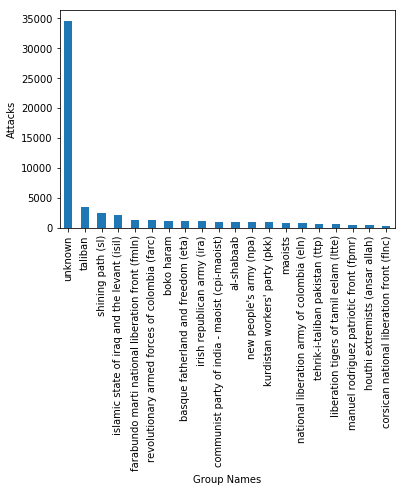

In [30]:
# Group wise terrorist attacks (top 20)
country_by_attacks = terror_df[['gname','iyear']].groupby('gname').count().sort_values('iyear',ascending=0).head(20)
country_by_attacks.plot(kind='bar',legend=False)
plt.xlabel('Group Names')
plt.ylabel('Attacks')
plt.show()

In [31]:
unknown_df= terror_df[terror_df['gname'] == "unknown"]

In [32]:
unknown_df.head(10)

,iyear,extended,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,property,country_txt,attacktype1_txt,targtype1_txt,weaptype1_txt,gname,has_casualties
135298,2014,0,0,1,1,1,0,0,0.0,0,0,United Kingdom,Bombing/Explosion,Unknown,Explosives/Bombs/Dynamite,unknown,0
131322,2014,0,0,1,1,1,0,0,1.0,0,0,Iraq,Armed Assault,Terrorists/Non-State Militia,Firearms,unknown,1
193626,1984,0,0,1,1,1,0,1,1.0,0,1,Chile,Bombing/Explosion,Utilities,Explosives/Bombs/Dynamite,unknown,0
260684,2008,0,0,1,1,1,0,0,1.0,1,1,Afghanistan,Bombing/Explosion,Government (Diplomatic),Explosives/Bombs/Dynamite,unknown,1
264925,2009,0,0,1,1,1,0,0,1.0,0,1,Georgia,Bombing/Explosion,Utilities,Explosives/Bombs/Dynamite,unknown,0
671,1971,0,0,1,1,1,0,0,1.0,0,1,West Germany (FRG),Bombing/Explosion,Government (Diplomatic),Explosives/Bombs/Dynamite,unknown,0
127221,2014,0,0,1,1,1,0,0,1.0,0,1,Libya,Assassination,Police,Firearms,unknown,1
320534,2015,0,0,1,1,1,0,1,1.0,0,0,Libya,Bombing/Explosion,Private Citizens & Property,Explosives/Bombs/Dynamite,unknown,1
104693,2011,0,0,1,1,1,0,0,1.0,0,1,Iraq,Bombing/Explosion,Private Citizens & Property,Explosives/Bombs/Dynamite,unknown,1
277500,2012,0,0,1,1,1,0,0,1.0,0,1,Pakistan,Bombing/Explosion,Utilities,Explosives/Bombs/Dynamite,unknown,0


In [33]:
terror_df = terror_df[~terror_df.isin(unknown_df)]

In [34]:
terror_df.shape
terror_df=terror_df.drop(["iyear"], axis=1)
terror_df= terror_df.dropna()

In [35]:
unknown_df.shape

(34610, 17)

In [36]:
Y = terror_df["gname"]


In [37]:
Y.shape

(43524,)

In [38]:
X = terror_df.drop(["gname"], axis=1)
X.dtypes

extended           float64
vicinity           float64
crit1              float64
crit2              float64
crit3              float64
doubtterr          float64
multiple           float64
success            float64
suicide            float64
property           float64
country_txt         object
attacktype1_txt     object
targtype1_txt       object
weaptype1_txt       object
has_casualties     float64
dtype: object

In [39]:
X["country_txt"] = pd.get_dummies(X["country_txt"])
X["attacktype1_txt"] = pd.get_dummies(X["attacktype1_txt"])
X["targtype1_txt"] = pd.get_dummies(X["targtype1_txt"])
X["weaptype1_txt"] = pd.get_dummies(X["weaptype1_txt"])


In [40]:
Y_count= Y.value_counts()


In [41]:
Y_bins=pd.qcut(Y_count, [0, .5, .75, 1], labels=["Small Org", "Medium Org" ,"Dangerous Groups"])


In [42]:
Y_bins.shape

(2186,)

In [43]:
Y_bins= Y_bins.to_dict()

In [44]:
Y=Y.reset_index()
Y=Y.drop(["index"], axis=1)


In [45]:
Y.head(1000)


,gname
0,shining path (sl)
1,allied democratic forces (adf)
2,al-nusrah front
3,revolutionary cells
4,tehrik-i-taliban pakistan (ttp)
5,taliban
6,islamic state of iraq and the levant (isil)
7,communist party of india - maoist (cpi-maoist)
8,farabundo marti national liberation front (fmln)
9,taliban


In [46]:
Label = []

for x in Y["gname"]:
    for key, value in Y_bins.items():
           if x==key:
            Label.append(value)

Y["Label"]= pd.Series(Label)            

In [47]:
Y.head(10)

,gname,Label
0,shining path (sl),Dangerous Groups
1,allied democratic forces (adf),Dangerous Groups
2,al-nusrah front,Dangerous Groups
3,revolutionary cells,Dangerous Groups
4,tehrik-i-taliban pakistan (ttp),Dangerous Groups
5,taliban,Dangerous Groups
6,islamic state of iraq and the levant (isil),Dangerous Groups
7,communist party of india - maoist (cpi-maoist),Dangerous Groups
8,farabundo marti national liberation front (fmln),Dangerous Groups
9,taliban,Dangerous Groups


In [48]:
Y= Y.drop(["gname"],axis=1)


In [49]:
Y = pd.get_dummies(Y)

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split


# Split the data into 25% test and 75% training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [51]:
X.shape

(43524, 15)

In [52]:
Y.shape

(43524, 3)

In [53]:
classifier = ExtraTreesClassifier()


feature_labels = [
    
    ## Spatio-Temporal Variables:
                 
    

                'extended', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr',
                'multiple', 'success', 'suicide', 
                'claimed', 'property', 
   
                'nkill', 'nwound',               
    
 
                'country_txt', 'attacktype1_txt', 'targtype1_txt',
                'weaptype1_txt']

# Train the classifier
classifier.fit(X, Y)
for feature in zip(feature_labels, classifier.feature_importances_):
    print(feature)

('extended', 0.047278545066866323)
('vicinity', 0.084292349532781891)
('crit1', 0.0)
('crit2', 0.0)
('crit3', 0.0)
('doubtterr', 0.0)
('multiple', 0.23549294081876543)
('success', 0.02717327810400761)
('suicide', 0.028830562342478466)
('claimed', 0.099010840116044427)
('property', 0.19983226341594268)
('nkill', 0.051062981050404098)
('nwound', 0.010491029475412883)
('country_txt', 0.032378187185554429)
('attacktype1_txt', 0.1841570228917418)


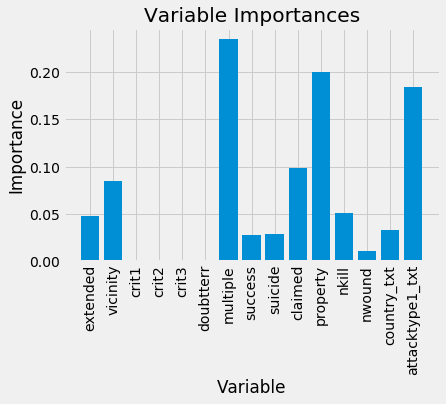

In [54]:
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(classifier.feature_importances_)))
# Make a bar chart
plt.bar(x_values, classifier.feature_importances_ , orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_labels, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [55]:
#LSTM
X_train.drop(["crit1", "crit2", "crit3", "doubtterr"], axis=1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train= pca.transform(X_train)



In [56]:
from sklearn.ensemble import RandomForestClassifier
